In [1]:
%matplotlib inline
import numpy as np
import copy as cp
import os.path
import matplotlib.pyplot as plt
import sys
import pickle
import scipy.misc as scm
import seaborn as sns
import matplotlib.cm as cm


from scipy import stats
import sklearn
from sklearn import datasets
from sklearn.semi_supervised import label_propagation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

from PIL import Image
from pylab import *


In [2]:
system = 'SiO2-Al2O3-MgO'
field_size = []  #                                                                                                         
LP_algorithm = 'LP'                                                                    
US_strategy = 'LC'      
initial_random = 9 
total_trials = 400#250 #400                                                                                                 
total_episodes = 1
is_output_img = True
use_cross_selection = True
fig_title = "Sampling by LP+LC for SiO$_2$-Al$_2$O$_3$-MgO" 



img = Image.open('PD_examples/SiO2-Al2O3-MgO_labeled.png')
phase_class = 10
    
    
rgb = img.convert('RGB')
img_array = np.asarray(rgb)/255.


xlabel = ' '
ylabel = ' '

In [3]:

field_range = [[140, 305], [1453, 1425]] 
field_size = [field_range[1][0] - field_range[0][0], field_range[1][1] - field_range[0][1]]
axis_range = [[0, 10000], [0, 17321]] #x_axis, y_axis


def drange(begin, end, step):
    n = begin
    while n+step < end:
        yield n
        n += step


In [4]:
#grid point list



temp_range = [0, 10000, round(10000./40)] 
prs_range = [0, 17321, round(17321./40)] 

if system == 'SiO2-Al2O3-MgO':
    grid_list = []
    grid_list_list = [[], [], [], [], [], [], [], [], [], []]
    sgn=1
    for y in range(prs_range[0], prs_range[1], prs_range[2]):
        for x in range(temp_range[0], temp_range[1], temp_range[2]):
            shift = 0 if sgn==1 else 0.5*temp_range[2]
            x=round(x+shift)
            yf = round(field_range[1][1] - ((float(y) - prs_range[0])/(prs_range[1] - prs_range[0]))*field_size[1]) 
            xf = round(field_range[0][0] + ((float(x)- temp_range[0])/(temp_range[1] - temp_range[0]))*field_size[0])
            
            rgb = img_array[yf][xf]
            if np.linalg.norm(rgb - np.array([0,0,0]))<0.1:
                continue
            elif np.linalg.norm(rgb - np.array([1,0,0]))<0.1:
                grid_list.append([y, x, 0])
                grid_list_list[0].append([y,x])
            elif np.linalg.norm(rgb - np.array([0,1,0]))<0.1:
                grid_list.append([y, x, 1])
                grid_list_list[1].append([y,x])
            elif np.linalg.norm(rgb - np.array([0,0,1]))<0.1:
                grid_list.append([y, x, 2])
                grid_list_list[2].append([y,x])
            elif np.linalg.norm(rgb - np.array([0,1,1]))<0.1:
                grid_list.append([y, x, 3])
                grid_list_list[3].append([y,x])
            elif np.linalg.norm(rgb - np.array([1,0,1]))<0.1:
                grid_list.append([y, x, 4])
                grid_list_list[4].append([y,x])
            elif np.linalg.norm(rgb - np.array([1,1,0]))<0.1:
                grid_list.append([y, x, 5])
                grid_list_list[5].append([y,x])
            elif np.linalg.norm(rgb - np.array([1,1,1]))<0.1:
                grid_list.append([y, x, 6])
                grid_list_list[6].append([y,x])
            elif np.linalg.norm(rgb - np.array([0.5, 0, 0]))<0.1:
                grid_list.append([y, x, 7])
                grid_list_list[7].append([y,x])
            elif np.linalg.norm(rgb - np.array([0, 0.5, 0]))<0.1:
                grid_list.append([y, x, 8])
                grid_list_list[8].append([y,x])
            elif np.linalg.norm(rgb - np.array([0, 0, 0.5]))<0.1:
                grid_list.append([y, x, 9])
                grid_list_list[9].append([y,x])
                
        sgn = sgn*(-1)
        
    grid_list = np.array(grid_list)
        

In [5]:
#Standardization

ss = StandardScaler()
ss.fit(grid_list[:,0:2])
grid_list_std = ss.transform(grid_list[:,0:2])


/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


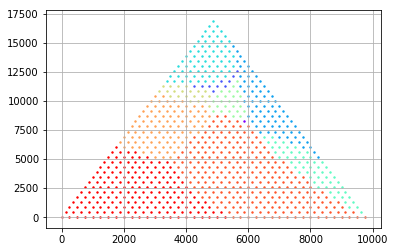

In [6]:
color_list = [cm.rainbow(float(i)/(phase_class-1)) for i in range(phase_class)]

for i in range(phase_class):
    plt.scatter(np.array(grid_list_list[i])[:,1],np.array(grid_list_list[i])[:,0], s=2, color = color_list[i])
if system == 'H2O_detail':
    plt.xlim(-60,30)
    plt.ylim(0,1000)
elif system == 'H2O':
    plt.xlim(-273,374)
    plt.ylim(0,80)
plt.grid()
plt.savefig('grid_label.png', dpi=300)
plt.show()

In [7]:
def cross_selection(prev_grid_id, unlabeled_indices, grid_list, system):

    if system == 'SiO2-Al2O3-MgO':
        
        candidate_indices = []
        for ui in unlabeled_indices:
            difx_step = (grid_list[prev_grid_id][1] - grid_list[ui][1])/(round(10000./40)/2)
            if grid_list[ui][0] == grid_list[prev_grid_id][0] or np.abs(grid_list[prev_grid_id][0]-grid_list[ui][0]) == np.abs(round(17321./40)*difx_step):
                candidate_indices.append(ui)
        if len(candidate_indices)>0:
            return candidate_indices
        else:
            return unlabeled_indices
        

/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with n

trial: 9


/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=1000 was reached without convergence.
  category=ConvergenceWarning
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00         1
          1       0.00      0.00      0.00        10
          2       0.54      0.77      0.63        77
          3       0.69      0.92      0.79        71
          4       0.00      0.00      0.00        57
          5       0.00      0.00      0.00        24
          6       0.00      0.00      0.00        21
          7       0.55      0.82      0.66        98
          8       0.80      0.80      0.80       270
          9       0.88      0.93      0.90       191

avg / total       0.64      0.73      0.68       820

macro_report (0.34587887374543425, 0.4224754825273118, 0.3779578633485591, None) [2 3 7 8 9]


/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=1000 was reached without convergence.
  category=ConvergenceWarning
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/F

classes [2 3 7 8 9]
[1732 1000    9]
[14722  4750     3]
[9093 3125    7]
[3897 1625    9]
[9959 3375    7]
[15588  5000     3]
[15588  4500     3]
[8660 6500    2]
[3464 5000    8]


/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: Matplotli

trial: 10


/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=1000 was reached without convergence.
  category=ConvergenceWarning
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00         1
          1       0.00      0.00      0.00        10
          2       0.82      0.61      0.70        77
          3       0.67      0.92      0.77        71
          4       0.00      0.00      0.00        57
          5       0.00      0.00      0.00        24
          6       0.00      0.00      0.00        21
          7       0.62      0.64      0.63        98
          8       0.65      0.99      0.79       270
          9       0.92      0.74      0.82       191

avg / total       0.64      0.71      0.66       820

macro_report (0.36880480137790944, 0.39047878009680237, 0.37167257610377047, None) [2 3 7 8 9]


/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=1000 was reached without convergence.
  category=ConvergenceWarning
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/F

classes [2 3 7 8 9]
[1732 1000    9]
[14722  4750     3]
[9093 3125    7]
[3897 1625    9]
[9959 3375    7]
[15588  5000     3]
[15588  4500     3]
[8660 6500    2]
[3464 5000    8]
[5629 4375    8]


/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: Matplotli

trial: 11


/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=1000 was reached without convergence.
  category=ConvergenceWarning
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/terayama/Downloads/ENTER/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00         1
          1       0.00      0.00      0.00        10
          2       0.94      0.60      0.73        77
          3       0.67      0.92      0.77        71
          4       0.00      0.00      0.00        57
          5       0.76      0.79      0.78        24
          6       0.00      0.00      0.00        21
          7       0.68      0.64      0.66        98
          8       0.66      0.97      0.79       270
          9       0.92      0.76      0.83       191

avg / total       0.68      0.73      0.69       820

macro_report (0.46327042254944334, 0.46858913445061223, 0.4564347216773042, None) [2 3 5 7 8 9]


KeyboardInterrupt: 

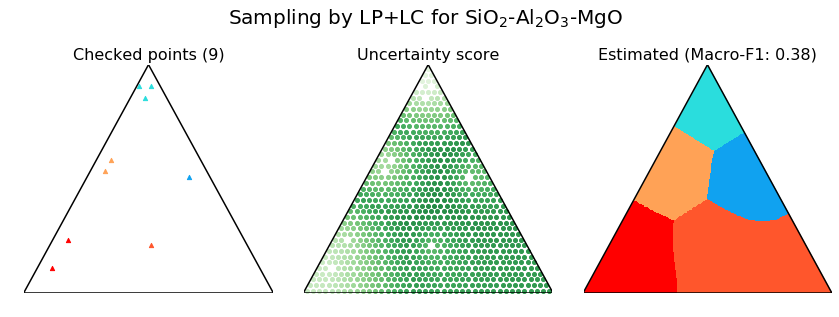

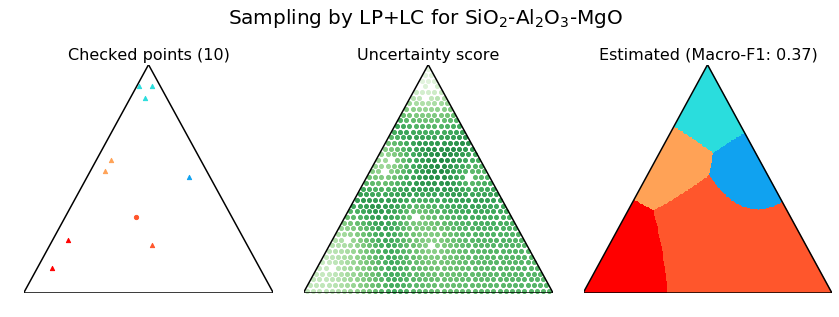

In [8]:
random_seed = 46
np.random.seed(random_seed)




for episode in range(total_episodes):
    random_list = np.random.permutation(range(len(grid_list))) 
    
    
    for trial in range(initial_random):
        if trial == 0:
            labeled_indices = random_list[0:1]
            unlabeled_indices = np.array([i for i in range(len(grid_list)) if i not in labeled_indices])
        else:
            label_train = np.copy(grid_list[:,2])
            label_train[unlabeled_indices] = -1
            lp_LS_model = label_propagation.LabelSpreading()
            lp_LS_model.fit(grid_list_std, label_train)
            predicted_LS_all_labels = lp_LS_model.transduction_
            true_labels = np.array(grid_list[:,2])[unlabeled_indices]

            macro_report = precision_recall_fscore_support(np.copy(grid_list[:,2]), predicted_LS_all_labels, average="macro")

    
            if use_cross_selection:
                cand_indices = cross_selection(labeled_indices[-1], unlabeled_indices, grid_list, system)
                next_index = [np.random.permutation(cand_indices)[0]]
                labeled_indices = np.concatenate([labeled_indices, np.array(next_index)])
                unlabeled_indices = np.array([i for i in range(len(grid_list)) if i not in labeled_indices])
            else:
                next_index = [np.random.permutation(unlabeled_indices)[0]]
                labeled_indices = np.concatenate([labeled_indices, np.array(next_index)])
                unlabeled_indices = np.array([i for i in range(len(grid_list)) if i not in labeled_indices])






    f1_score_list = []

    for trial in range(total_trials - initial_random+1):
        print('trial:', trial+initial_random)


        label_train = np.copy(grid_list[:,2])
        label_train[unlabeled_indices] = -1

            
        if LP_algorithm == 'LS_rbf':
            lp_model = label_propagation.LabelSpreading()
        elif LP_algorithm == 'LS_knn':
            lp_model = label_propagation.LabelSpreading(kernel='knn')
        elif LP_algorithm == 'LP':
            lp_model = label_propagation.LabelPropagation()
            
            
        
        if LP_algorithm in ['LS_rbf', 'LS_knn', 'LP'] :
            lp_model.fit(grid_list_std, label_train)
            predicted_labels = lp_model.transduction_[unlabeled_indices]
            predicted_all_labels = lp_model.transduction_
            label_distributions = lp_model.label_distributions_[unlabeled_indices]
            label_distributions_all = lp_model.label_distributions_
            classes = lp_model.classes_
        
        
        print(classification_report(np.copy(grid_list[:,2]), predicted_all_labels))
        macro_report = precision_recall_fscore_support(np.copy(grid_list[:,2]), predicted_all_labels, average="macro")
        print('macro_report', macro_report, classes)
        
       



        if US_strategy == 'E':
            pred_entropies = stats.distributions.entropy(label_distributions.T)
            u_score_list = pred_entropies/np.max(pred_entropies)
            if use_cross_selection:
                cand_indices = cross_selection(labeled_indices[-1], unlabeled_indices, grid_list, system)
                pred_entropies_all = stats.distributions.entropy(label_distributions_all.T)
                cand_E_list = []
                for i in cand_indices:
                    cand_E_list.append(pred_entropies_all[i])
                uncertainty_index = [cand_indices[np.argmax(cand_E_list)]]
            else:
                uncertainty_index = [unlabeled_indices[np.argmax(pred_entropies)]]
            
            
        elif US_strategy == 'LC':

            u_score_list = 1- np.max(label_distributions, axis = 1)
            if use_cross_selection:
                cand_indices = cross_selection(labeled_indices[-1], unlabeled_indices, grid_list, system)
                cand_LC_list = []
                for i in cand_indices:
                    cand_LC_list.append(label_distributions_all[i])
                
                uncertainty_index = [cand_indices[np.argmax(1- np.max(np.array(cand_LC_list), axis = 1))]]
            else:
                uncertainty_index = [unlabeled_indices[np.argmax(1- np.max(label_distributions, axis = 1))]]
            
        elif US_strategy == 'MS':

            u_score_list = []
            for pro_dist in label_distributions:
                pro_ordered = np.sort(pro_dist)[::-1]
                margin = pro_ordered[0] - pro_ordered[1]
                u_score_list.append(margin)

            if use_cross_selection:
                cand_indices = cross_selection(labeled_indices[-1], unlabeled_indices, grid_list, system)
                cand_margin_list = []
                for i in cand_indices:
                    pro_ordered = np.sort(label_distributions_all[i])[::-1]
                    margin = pro_ordered[0] - pro_ordered[1]
                    cand_margin_list.append(margin)
                uncertainty_index = [cand_indices[np.argmin(cand_margin_list)]]    
            else:
                uncertainty_index = [unlabeled_indices[np.argmin(u_score_list)]]
            u_score_list = 1-  np.array(u_score_list)
        elif US_strategy == 'RS':
            if use_cross_selection:
                cand_indices = cross_selection(labeled_indices[-1], unlabeled_indices, grid_list, system)
                uncertainty_index = [np.random.permutation(cand_indices)[0]]
            else:
                uncertainty_index = [np.random.permutation(unlabeled_indices)[0]]
            u_score_list = [0.5 for i in range(len(label_distributions))]
            
        
        
            
            

        if is_output_img and (trial+initial_random) % 1 == 0 :
            if system == 'SiO2-Al2O3-MgO':
                gamma_F = 75

            if LP_algorithm == 'LP':
                lp_model = label_propagation.LabelPropagation(gamma=gamma_F) #H2O_detailの時gamma=25
            elif LP_algorithm == 'LS_rbf':
                lp_model = label_propagation.LabelSpreading(gamma=gamma_F)
            lp_model.fit(grid_list_std, label_train)
            predicted_labels_F = lp_model.transduction_[unlabeled_indices]
            predicted_all_labels_F = lp_model.transduction_
            label_distributions_F = lp_model.label_distributions_[unlabeled_indices]
            label_distributions_all_F = lp_model.label_distributions_
            classes = lp_model.classes_
            print("classes", classes)
            
            
            macro_report_F = precision_recall_fscore_support(np.copy(grid_list[:,2]), predicted_all_labels_F, average="macro")

            
            plt.rcParams['xtick.direction'] = 'in'
            plt.rcParams['ytick.direction'] = 'in'
            
            plt.figure(figsize=(12, 4.5))
            plt.rcParams["font.size"] = 13
            ax = plt.subplot(131)
            count=0
            init_num = 9 if initial_random == -1 else initial_random 
            for i in labeled_indices:
                print(grid_list[i])
                if count < init_num:
                    plt.scatter(grid_list[i][1], grid_list[i][0], s =18, c=color_list[grid_list[i][2]], marker="^")
                else:
                    plt.scatter(grid_list[i][1], grid_list[i][0], s =18, c=color_list[grid_list[i][2]])
                count+=1

            plt.xlim(temp_range[0], temp_range[1])
            plt.ylim(prs_range[0], prs_range[1])
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)

            ax.tick_params(labelbottom="off",bottom="off")
            ax.tick_params(labelleft="off",left="off")
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['left'].set_visible(False)
            plt.gca().spines['bottom'].set_visible(False)
            x = np.linspace(-100,10000,4)  
            y = 0*x -150         
            plt.plot(x-120 ,y,color='black')
            y = 2*1.732*x-90              
            plt.plot(x- 120  ,y,color='black')
            y = 2*1.732*10000 - 2*1.732*x -90           
            plt.plot(x- 120 ,y,color='black')
            plt.xlim(temp_range[0]-120, temp_range[1]-120)
            plt.ylim(prs_range[0]-150, prs_range[1]-90)

  
                
            plt.title('Checked points ('+str(trial+initial_random)+')', size = 16)

            x = np.arange(0, 300)/300.
            x = temp_range[0]+(temp_range[1] - temp_range[0])*x
            y = np.arange(0, 300)/300.
            y = prs_range[0]+(prs_range[1] - prs_range[0])*y
            
            mesh_list = []
            for yy in y:
                for xx in x:
                    mesh_list.append([yy, xx])
            pred_label = lp_model.predict(ss.transform(mesh_list))
     
            X, Y = np.meshgrid(x, y)
            Z = np.reshape(pred_label, (len(y), len(x)))
            z_min = 0
            z_max = phase_class

           
            fig = plt.subplot(132)

            u_score_colors = cm.Greens(u_score_list)
            
            for i in range(len(grid_list[unlabeled_indices])):
                if i% 1 == 0:
                    
                    plt.scatter(grid_list[unlabeled_indices][i][1], grid_list[unlabeled_indices][i][0], c= u_score_colors[i], s=16)
                    
            plt.colorbar
            plt.xlim(temp_range[0], temp_range[1])
            plt.ylim(prs_range[0], prs_range[1])
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            if system == 'SiO2-Al2O3-MgO':
                fig.tick_params(labelbottom="off",bottom="off")
                fig.tick_params(labelleft="off",left="off")
                plt.gca().spines['right'].set_visible(False)
                plt.gca().spines['top'].set_visible(False)
                plt.gca().spines['left'].set_visible(False)
                plt.gca().spines['bottom'].set_visible(False)
                x = np.linspace(-100,10000,4)  # xの値域(0, 1, 2, 3)
                y = 0*x -150         # 直線の式
                plt.plot(x-120 ,y,color='black')
                y = 2*1.732*x-90              # 直線の式
                plt.plot(x- 120  ,y,color='black')
                y = 2*1.732*10000 - 2*1.732*x -90           # 直線の式
                plt.plot(x- 120 ,y,color='black')
                plt.xlim(temp_range[0]-120, temp_range[1]-120)
                plt.ylim(prs_range[0]-150, prs_range[1]-90)
            plt.title('Uncertainty score', size = 16)
            
            ax = plt.subplot(133)
            """
            plt.imshow(Z, cmap='RdBu', vmin=z_min, vmax=z_max,shape = (500, 500),
                       #extent=[X.min(), X.max(), Y.min(), Y.max()*100], #extent=[X.min()*10, X.max()*10, Y.min(), Y.max()],
                       interpolation='nearest', origin='lower')
            """
            #print('Z', Z)
            #print('Z/float(phase_class+10)',Z/float(phase_class+10))
            plt.pcolormesh(X, Y, Z, cmap='rainbow', vmin=0, vmax=phase_class-1)
            #plt.title('Estimated phase diagram')
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.xlim(temp_range[0], temp_range[1])
            plt.ylim(prs_range[0], prs_range[1])
            if system == 'SiO2-Al2O3-MgO':
                ax.tick_params(labelbottom="off",bottom="off")
                ax.tick_params(labelleft="off",left="off")
                plt.gca().spines['right'].set_visible(False)
                plt.gca().spines['top'].set_visible(False)
                plt.gca().spines['left'].set_visible(False)
                plt.gca().spines['bottom'].set_visible(False)
                x = np.linspace(0,10000,4)  
                y = 0*x -5             #
                plt.plot(x- 15  ,y,color='black')
                y = 2*1.732*x -5               
                plt.plot(x- 15  ,y,color='black')
                y = 2*1.732*10000 - 2*1.732*x -5              
                plt.plot(x- 15  ,y,color='black')
            
                x = np.arange(-100,5000,1)
                y1 = 2*1.732*x 
                y2 = 0*x+20000
                plt.fill_between(x,y1,y2,facecolor='white')
                x = np.arange(5000,10000,1)
                y1 = 10000*2*1.732 - 2*1.732*x 
                y2 = 0*x+20000
                plt.fill_between(x,y1,y2,facecolor='white')
            
            
            plt.title('Estimated (Macro-F1: '+"{0:.2f}".format(macro_report[2])+')', size = 16)
            

            plt.suptitle(fig_title, fontsize=20)
            plt.tight_layout()
            plt.subplots_adjust(top=0.8)

            output_img_dir = 'snapshot/'+system+'_'+LP_algorithm+'_'+US_strategy+'_CS'+str(use_cross_selection)+'_init'+str(initial_random)+'_seed'+str(random_seed)+'_trial'+str(trial)+'.png'
            plt.savefig(output_img_dir, dpi = 300)
        
        labeled_indices = np.concatenate([labeled_indices, np.array(uncertainty_index)])
        unlabeled_indices = np.array([i for i in range(len(grid_list)) if i not in labeled_indices])


  
        
        